# TP Large Scale Kernel Methods

Large scale methode is a way to transform X into special forms with needs, and train and test the transformed X. Large Scale Kernel Methodes are usually used in SVM methode.

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = '/Users/didi/Documents/Telecom/MDI341/TP/Large_Scale_Kernel/ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [3]:
from sklearn.svm import SVC, LinearSVC
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC(kernel='rbf') #rbf stands for Radial basis function
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
accuracy_kernel = clf.score(X_test, y_test)

print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)

# TODO same for LinearSVC
print("Fitting LinearSVC on %d samples..." % X_train.shape[0])
t2 = time()
clf_l = LinearSVC(dual=False)
clf_l.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t2))

print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t3 = time()
accuracy_kernel_l = clf_l.score(X_test, y_test)

print("done in %0.3fs" % (time() - t3))
timing_kernel = time() - t2
print("classification accuracy: %0.3f" % accuracy_kernel_l)


Fitting SVC rbf on 20000 samples...
done in 2.814s
Predicting with SVC rbf on 40000 samples...
done in 3.148s
classification accuracy: 0.980
Fitting LinearSVC on 20000 samples...
done in 0.074s
Predicting with LinearSVC on 40000 samples...
done in 0.011s
classification accuracy: 0.917


<strong>Conclusion: </strong>
- For Training and Prediction : LinearSVC is much more faster than SVC 
- For Classification accuracy : SVC is better than LinearSVC

- In total: LinearSVC is faster, but SVC is more accurate

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [4]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, s, vt = svds(gram_mat, k)
        gram_mat_k = u@np.diag(s)@vt
        #pass  # TODO
    else:
        u, s, vt = svd(gram_mat)
        gram_mat_k = u[:,:k]@np.diag(s)[:k,:k]@vt[:k,:]
        #pass  # TODO
    return gram_mat_k

## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [5]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rel_error_f = []
rel_error_s = []

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)

n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error_fast = np.zeros(n_ranks)
rel_error_slow = np.zeros(n_ranks)


for k, rank in enumerate(ranks):
    t0 = time()
    gram_mat_k_fast = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k_slow = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0
    
    # TODO: compute relative error with Frobenius norm
    rel_error_fast[k] = np.linalg.norm(gram_mat_k_fast - gram_signal, ord='fro')/np.linalg.norm(gram_signal, ord='fro')
    rel_error_slow[k] = np.linalg.norm(gram_mat_k_slow - gram_signal, ord='fro')/np.linalg.norm(gram_signal, ord='fro')


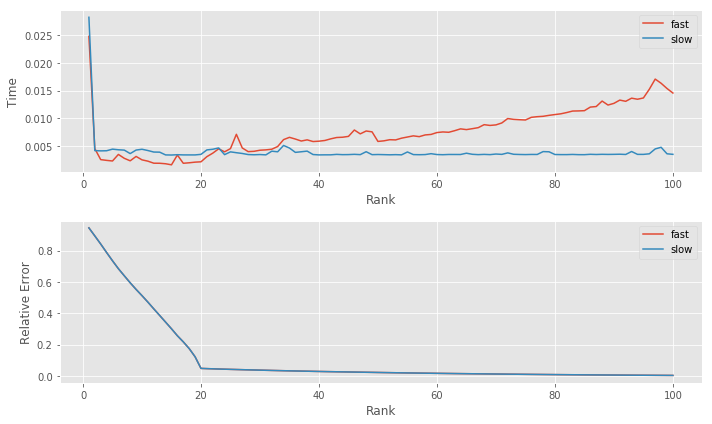

In [6]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()
ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')

ax2.plot(ranks, rel_error_fast, '-', label='fast')
ax2.plot(ranks, rel_error_slow, '-', label='slow')
ax2.legend()
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')

plt.tight_layout()
plt.show()

<strong>Observation:</strong>
- The first graph shows the relation between ranks and time of calculation. We can see that the fast version is faster in the first 20 ranks, then it becomes more and more slower. The time of slow version is constant.
- The second graph shows the relation between ranks and relative error. We can see that the error decreases very fast until ranks equals to 20, then error becomes almost plat. 

<strong>Conclusion:</strong>
- If we decide to use a large Gram rank, then the slow version is a good choice in terms of timing.
- In our case, the best approximation of Gram rank is 20.

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [7]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    # TODO
    w = rng.normal(0, np.sqrt(2*gamma), (n_features, c))
    b = rng.uniform(0, 2*np.pi, (1, c))
    
    X_new_train = np.sqrt(2/c)*np.cos(np.dot(X_train, w) + b)
    X_new_test = np.sqrt(2/c)*np.cos(np.dot(X_test, w) + b)
    
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [8]:
Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 1.331s
Predicting with SVC linear on 40000 samples...
done in 0.020s
classification accuracy: 0.963


<strong>Conclusion</strong>: 
- Random Kernel Features method gives a better accuracy which is 0.963 compares to classical kernel which is 0.917. 
- However, Random Kernel Features method takes a bit more time than classical kernel method.

## Question 6

On implémente la méthode de Nystrom.

In [76]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    # TODO
    u, s, vt  = svd(W)
    gram_mat_k = u[:,:k]@np.diag(np.sqrt(1/s[:k]))
    c_train = rbf_kernel(X_train, X_train_idx)
    c_test = rbf_kernel(X_test, X_train_idx)
    X_new_train = c_train@gram_mat_k
    X_new_test = c_test@gram_mat_k
    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [77]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.022s
Predicting with SVC linear on 40000 samples...
done in 0.024s
classification accuracy: 0.976


<strong>Conclusion</strong>: 
- Nyström method gives the best accuracy which is 0.976 compares to Random Kernel Features method which is 0.963 and classical kernel which is 0.917. 
- Nyström method takes about the same time with Random Kernel Features method.

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [78]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_linear = np.zeros(n_ranks)
timing_rbf = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_linear = np.zeros(n_ranks)
accuracy_rbf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    r_train, r_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    n_train, n_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    clf = LinearSVC(dual=False)
   
    #random
    t0=time()
    clf.fit(r_train, y_train)
    timing_rkf[i] = time()-t0
    t1=time()
    accuracy = clf.score(r_test, y_test)
    
    accuracy_rkf[i] = accuracy
    
    #Nystrom
    t0=time()
    clf.fit(n_train, y_train)    
    accuracy = clf.score(n_test, y_test)
    timing_nystrom[i] = time()-t0
    accuracy_nystrom[i] = accuracy

    #Linear classic kernel
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(X_train, y_train)
    accuracy_linear[i] = clf.score(X_test, y_test)
    timing_linear[i] = time() - t0
    
    #RBF classic kernel
    t0 = time()
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    accuracy_rbf[i] = clf.score(X_test, y_test)
    timing_rbf[i] = time() - t0

Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


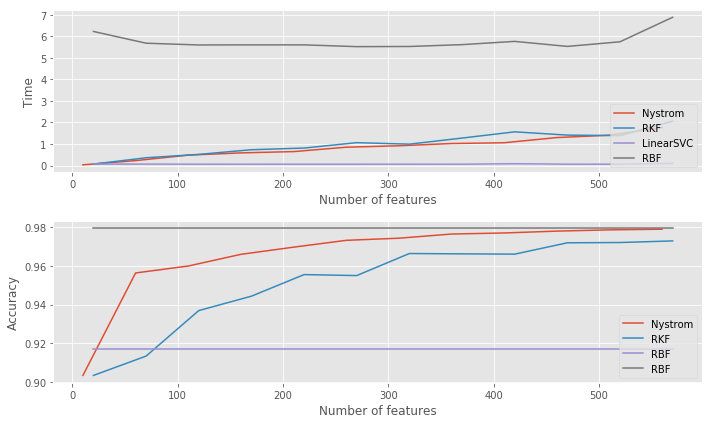

In [79]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_rbf * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_rbf * np.ones(n_ranks), '-', label='RBF')

ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

<strong>Observation:</strong>
- The first graph represent the relatin between time and ranks for the 4 methods. We can see that the RBF takes more time than other three. Nystrom takes slightly less time than RKF. And LinearSVC takes the least time
- The second graph represents the relationship between accuracy and ranks. We can see that the RBF method is the most accurate. With the increasing of ranks, Nystrom and RKF surpass the accuracy of LinearSVC at about rank = 20 and rank = 75 respectively, and are approaching to the accuracy of RBF method. It is interesting to see that while Nystrom surpass the LinearSVC, the rank value equals to the Gram approximation rank value.